# Secretory Reactions
Here we will map all the secretory reactions from the [Mammalian Secretory Pathway Reconstruction paper](https://www.nature.com/articles/s41467-019-13867-y) to the genes in our reconstruction.

1. Load Secretory Pathway Reactions

In [1]:
import re
import pandas as pd
import numpy as np
from google_sheet import GoogleSheet

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'
Met_Recon_SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)
met_recon_gsheet_file = GoogleSheet(Met_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_reactions_sheet = 'Reactions'
sec_genes_sheet = 'SecRecon'
sec_reactions = sec_recon_gsheet_file.read_google_sheet(sec_reactions_sheet)
sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)

# Read data from Metabolic Reconstruction
met_genes_sheet = 'Genes'
met_genes = met_recon_gsheet_file.read_google_sheet(met_genes_sheet)

# Create a copy of the SecRecon Reactions
sec_reactions_dc = sec_reactions.copy()

In [ ]:
# File paths
files = {
    "Reaction Abbreviation": 'Sec_Recon_Reactions/rxnAbbreviation_CHO.txt',
    "Components": 'Sec_Recon_Reactions/rxnComponents_CHO.txt',
    "Conditions": 'Sec_Recon_Reactions/rxnConditions_CHO.txt',
    "Formula": 'Sec_Recon_Reactions/rxnFormula_CHO.txt',
    "GPRs": 'Sec_Recon_Reactions/rxnGPRs_CHO.txt',
    "Pathway": 'Sec_Recon_Reactions/rxnPathway_CHO.txt',
}

# Initialize a dictionary to hold lists
data = {}

# Read each file
for column_name, file_path in files.items():
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file.readlines()]
        data[column_name] = lines[1:]  # Skip the header

# Equalize lengths
max_length = max(len(lst) for lst in data.values())
for column_name in data:
    data[column_name] += [np.nan] * (max_length - len(data[column_name]))

# Create DataFrame
df = pd.DataFrame(data)
df.columns = sec_reactions_dc.columns

In [ ]:
# Standarize data according the the metabolic reconstruction

for i,row in df.iterrows():

    # Standarize formula nomenclature
    formula = row['Reaction Formula']
    formula = formula.replace('[','_')
    formula = formula.replace(']','')
    formula = formula.replace('->','-->')
    df.at[i, 'Reaction Formula'] = formula
    
    # Standarize GPR nomenclature
    GPR = row['GPR_final']
    if (pd.isna(GPR) or GPR==''):
        continue
    else:
        GPR = re.sub(r'\((\d+)\)', r'\1', GPR)
        df.at[i, 'GPR_final'] = GPR

In [ ]:
sec_reactions_dc = df
if not sec_reactions_dc.equals(sec_reactions):
    sec_recon_gsheet_file.update_google_sheet(sec_reactions_sheet, sec_reactions_dc)
    print("Sec Recon Reactions Updated")
else:
    print('Reactions are up-to-date')

### Comparison with Secretory Pathway Reconstruction and Metabolic Reconstruction
Here we compare the genes in the Secretory Pathway Reconstruction to those in Jahir's reconstruction and our Metabolic Reconstruction

In [3]:
# Extract all the genes from SecRecon
sec_recon_genes = list(sec_genes['CHO ENTREZID'].replace('', pd.NA).dropna())

# Extract all the genes in Jahir's reconstrucion
gene_ids = []
    
for entry in sec_reactions['GPR_final'].dropna():  # Drop NaN values to avoid errors
    # Find all occurrences of gene IDs (assumed to be numerical)
    ids = re.findall(r'\b\d+\b', entry)
    gene_ids.extend(ids)
unique_gene_ids = list(set(gene_ids))

# Extract all the genes from Metabolic Reconstruction
met_recon_genes = list(met_genes['Gene Entrez ID'].replace('', pd.NA).dropna())

In [19]:
# Compare Gene IDs for the three datasets

# Convert lists to sets
sec_recon_genes_set = set(sec_recon_genes)
met_recon_genes_set = set(met_recon_genes)
unique_gene_ids_set = set(unique_gene_ids)

# Calculate intersections
common_secrecon_jahirs = sec_recon_genes_set.intersection(unique_gene_ids_set)
common_secrecon_metrecon = sec_recon_genes_set.intersection(met_recon_genes_set)
common_jahirs_metrecon = unique_gene_ids_set.intersection(met_recon_genes_set)
common_all = sec_recon_genes_set.intersection(met_recon_genes_set, unique_gene_ids_set) # common to all reconstructions
unique_secrecon_metrecon = common_secrecon_metrecon.difference(common_all) # genes shared by Sec Recon and Met Recon minus Jahir's
unique_sec_recon_genes = sec_recon_genes_set.difference(met_recon_genes_set,unique_gene_ids_set)

# Get the number of common elements
count_common_secrecon_jahirs = len(common_secrecon_jahirs)
count_common_secrecon_metrecon = len(common_secrecon_metrecon)
count_common_jahirs_metrecon = len(common_jahirs_metrecon)
count_unique_secrecon_metrecon = len(unique_secrecon_metrecon)

# Output the results
print(f"Number of unique gene IDs in both Sec Recon and Jahir's Reconstruction: {count_common_secrecon_jahirs}")
print(f"Number of unique gene IDs in both Sec Recon and Metabolic Reconstruction: {count_common_secrecon_metrecon}")
print(f"Number of unique gene IDs in both Jahir's Reconstruction and Metabolic Reconstruction: {count_common_jahirs_metrecon}")
print(f"Number of unique gene IDs in both Sec Recon and Metabolic Reconstruction (Not Inluding Jahir's Recon: {count_unique_secrecon_metrecon}")

# Save gene IDs interesections as txt files
with open('Output/reactions/common_secrecon_jahirs.txt', 'w') as file: file.writelines(f"{gene_id}\n" for gene_id in sorted(common_secrecon_jahirs))
with open('Output/reactions/common_secrecon_metrecon.txt', 'w') as file: file.writelines(f"{gene_id}\n" for gene_id in sorted(common_secrecon_metrecon))
with open('Output/reactions/common_jahirs_metrecon.txt', 'w') as file: file.writelines(f"{gene_id}\n" for gene_id in sorted(common_jahirs_metrecon))
with open('Output/reactions/unique_secrecon_metrecon.txt', 'w') as file: file.writelines(f"{gene_id}\n" for gene_id in sorted(unique_secrecon_metrecon))

Number of unique gene IDs in both Sec Recon and Jahir's Reconstruction: 228
Number of unique gene IDs in both Sec Recon and Metabolic Reconstruction: 411
Number of unique gene IDs in both Jahir's Reconstruction and Metabolic Reconstruction: 85
Number of unique gene IDs in both Sec Recon and Metabolic Reconstruction (Not Inluding Jahir's Recon: 326


In [21]:
len(unique_sec_recon_genes)

548

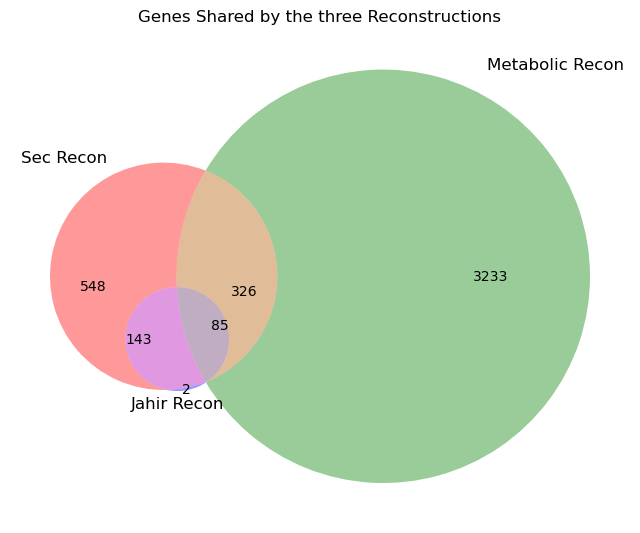

In [6]:
# Plotting the Venn diagram

plt.figure(figsize=(8, 8))  # Set the figure size as needed
venn_diagram = venn3([sec_recon_genes_set, met_recon_genes_set, unique_gene_ids_set], 
                     ('Sec Recon', 'Metabolic Recon', 'Jahir Recon'))
plt.title("Genes Shared by the three Reconstructions")
plt.savefig('Plots/venn_diagram_genes_sec_recon.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Get Gene Symbols for the CHO entrez IDs unique in Sec Recon
sec_genes_dict = sec_genes.set_index('CHO ENTREZID')['GENE SYMBOL'].to_dict()

unique_secrecon_human_gene_symbols = []
for cho_id in unique_sec_recon_genes:
    unique_secrecon_human_gene_symbols.append(sec_genes_dict[cho_id])

with open('Output/reactions/unique_secrecon_human_gene_symbols.txt', 'w') as file: file.writelines(f"{gene_id}\n" for gene_id in sorted(unique_secrecon_human_gene_symbols))